In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Ryan.Models.LSTM_model_Regression.preprocess import preprocess_data
from Ryan.Models.LSTM_model_Regression.lstm_models import  LSTMModel, LSTMModel_multi
from Ryan.Models.LSTM_model_Regression.run_fn import eval_fn, train_fn
from Ryan.Models.LSTM_model_Regression.load_data import load_data, create_sequences
from Ryan.Models.LSTM_model_Regression.load_data import load_data2
import torch
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load Data
use the `resampled_lob_secs2.csv` file as the test data (last 10%)

align the test index with the prediction index. The length of both should be the same (376707)

set `test_set=test_data[21:-1]` to align the test data with the prediction data

In [48]:
lob_data=pd.read_csv('E:\\Bristol\\mini_project\\JPMorgan_Set01\\test_datasets\\resampled_lob_secs2.csv')

loaded_pred=np.load('./saved_models_regression/predictions_new3.npy')
loaded_true=np.load('./saved_models_regression/actuals_new3.npy')

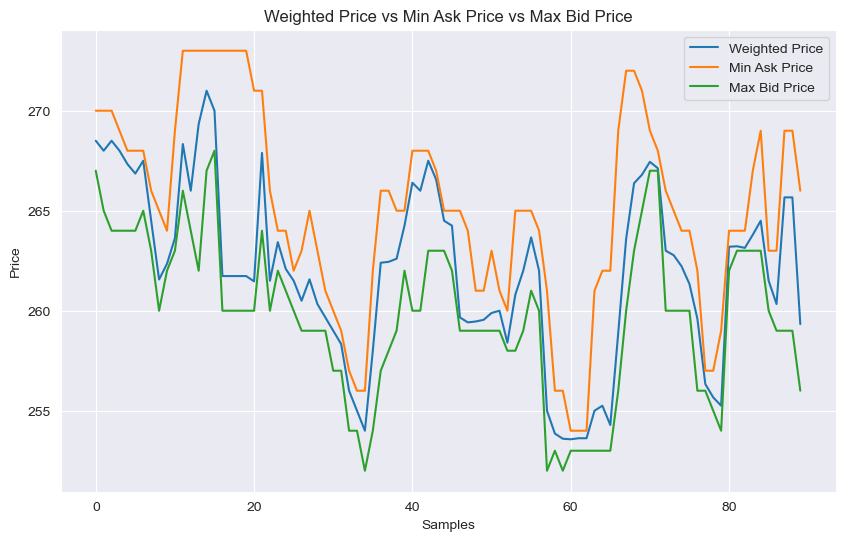

In [49]:
plt.figure(figsize=(10,6))
plt.plot(lob_data['price'][10:100].values, label='Weighted Price')
plt.plot(lob_data['Min Ask Price'][10:100].values, label='Min Ask Price')
plt.plot(lob_data['Max Bid Price'][10:100].values, label='Max Bid Price')
plt.legend()
plt.title('Weighted Price vs Min Ask Price vs Max Bid Price')
plt.ylabel('Price')
plt.xlabel('Samples')
plt.show()

In [50]:
split_index=int(0.9*len(lob_data))
train_data=lob_data.iloc[:split_index]
test_data=lob_data.iloc[split_index:]
test_set=test_data[21:-1]

test_set.reset_index(drop=True, inplace=True) # drop=True to avoid the old index being added as a column
test_set

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum
0,2025-06-13 04:28:47,256,109,193.000000,30,17,4,3,-7,56.384379,229.600000,83.142857
1,2025-06-13 04:28:48,274,112,184.000000,30,17,4,5,1,55.606061,244.400000,74.000000
2,2025-06-13 04:28:49,390,110,196.153846,39,17,4,9,-13,39.854729,224.630769,-98.846154
3,2025-06-13 04:28:50,207,109,126.818182,39,16,2,9,-7,16.606580,166.594406,-290.181818
4,2025-06-13 04:28:51,156,109,117.545455,39,17,2,9,2,45.163267,163.503497,-15.454545
...,...,...,...,...,...,...,...,...,...,...,...,...
376702,2025-07-01 08:17:54,169,109,139.000000,15,18,2,2,4,88.284519,117.257143,45.750000
376703,2025-07-01 08:17:55,183,109,133.666667,21,18,1,2,-1,79.558011,124.390476,35.666667
376704,2025-07-01 08:17:56,183,110,128.250000,24,18,1,3,3,81.702128,131.840476,37.250000
376705,2025-07-01 08:17:57,123,110,114.333333,26,18,1,2,0,34.012739,129.450000,-11.952381


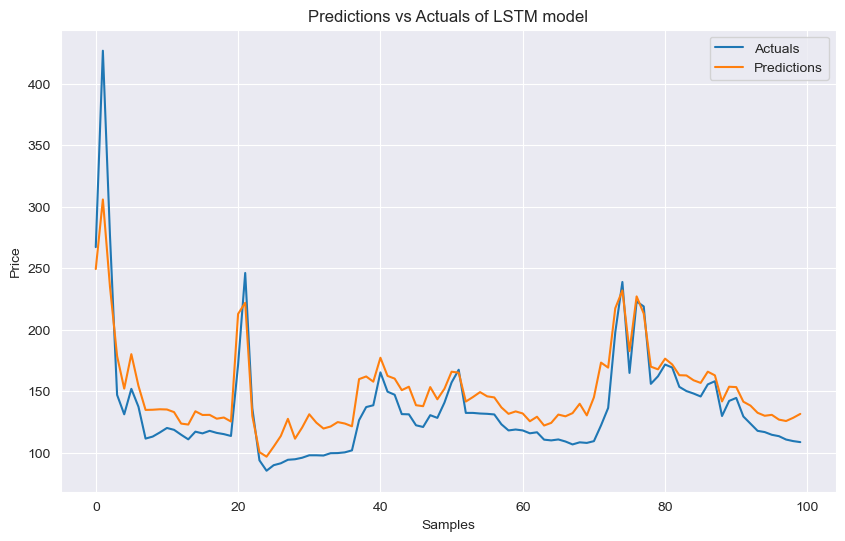

In [51]:
# use the true price in test set and predicted price to plot
plt.figure(figsize=(10,6))
plt.plot(test_set['price'][500:600].values, label='Actuals')
plt.plot(loaded_pred[500:600], label='Predictions')
plt.legend()
plt.title('Predictions vs Actuals of LSTM model')
plt.ylabel('Price')
plt.xlabel('Samples')
plt.show()

### Adjust the predictions
As the predictions on test set is higher than the actuals(in most cases), we need to adjust the predictions. We calculated the MAE of the model on train set and found that the MAE is around 14. So we can adjust the predictions by subtracting 14 from the predictions.

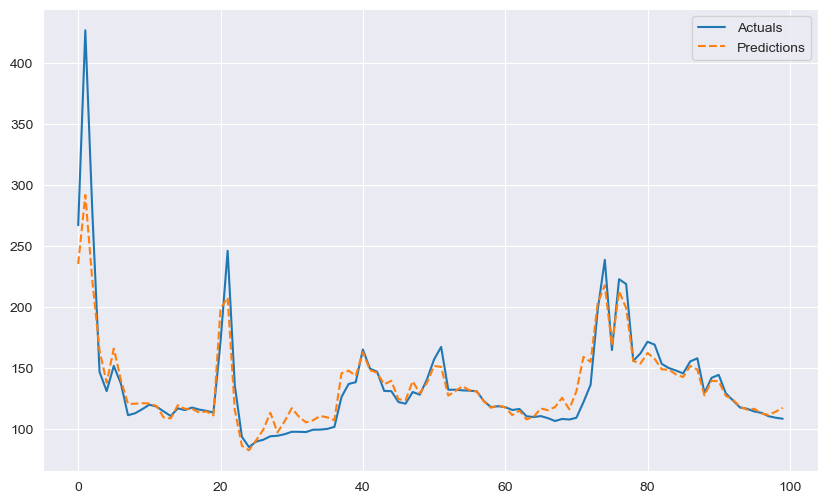

In [52]:
# adjust predicitons
loaded_pred_adjusted=loaded_pred-14

# plot
plt.figure(figsize=(10,6))
plt.plot(test_set['price'].values[500:600], label='Actuals')
plt.plot(loaded_pred_adjusted[500:600], label='Predictions',linestyle='dashed')
plt.legend()

# 2. Trading Strategy

## 2.1 Volatility

The number of trades is adjusted based on current market volatility and risk tolerance to ensure trades are in line with the investor's risk tolerance.

Volatility calculation: rolling standard deviation of log returns
Number of trades: Adjusted based on volatility, risk tolerance and maximum tradable volume

In [53]:
# This is only for trading volume, not for modeling
# # 设置一个时间窗口
rolling_window = 5  # 例如，我们使用过去5个时间点的数据来计算波动率

# 计算对数收益率 shift(1)是为了计算相对于前一分钟的收益率
test_set['Log Return Max Bid'] = np.log(test_set['Max Bid Price'] / test_set['Max Bid Price'].shift(1))
test_set['Log Return Min Ask'] = np.log(test_set['Min Ask Price'] / test_set['Min Ask Price'].shift(1))

# 计算滚动标准差作为波动率的度量
test_set['Volatility Max Bid'] = test_set['Log Return Max Bid'].rolling(window=rolling_window).std()
test_set['Volatility Min Ask'] = test_set['Log Return Min Ask'].rolling(window=rolling_window).std()

# 由于滚动计算会产生缺失值，我们通常会删除这些值
# lob_data.dropna(inplace=True)

# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_factor=10):
    """
    根据波动率和最大可交易量调整交易量。
    volatility: 当前波动率
    max_tradeable_quantity: 该时间点的最大可交易量（对于买入操作，是Min Ask Quantity；对于卖出操作，是Max Bid Quantity）
    base_quantity: 基础交易量
    risk_tolerance: 风险容忍度，取值范围为[0, 1]，数值越小表风险承受越大，交易量越大
    scaler_factor: 缩放因子，用于进一步调整基于波动率的交易量
    """
    # 确保风险容忍度和波动率不会导致除以0
    if volatility <= 0.0001:
        volatility = 0.0001
    if risk_tolerance <= 0:
        risk_tolerance = 0.1  # 设置一个默认的风险容忍度，避免除以0

    # 基于波动率调整的交易量
    adjusted_quantity = base_quantity / (volatility * risk_tolerance * scaler_factor)
    adjusted_quantity = max(1, round(adjusted_quantity))  # 确保至少交易1单位，并且是整数

    # 确保交易量不超过最大可交易量
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\683973121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Log Return Max Bid'] = np.log(test_set['Max Bid Price'] / test_set['Max Bid Price'].shift(1))
C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\683973121.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Log Return Min Ask'] = np.log(test_set['Min Ask Price'] / test_set['Min Ask Price'].shift(1))
C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\683973121.py:10: SettingWithCopyWarn

## 2.2 MACD


In [97]:
# short term EMA
ema_short = test_set['price'].ewm(span=300, adjust=False).mean()
# long term EMA
ema_long = test_set['price'].ewm(span=600, adjust=False).mean()
# MACD line
macd = ema_short - ema_long
# signal line
signal = macd.ewm(span=60, adjust=False).mean()
# histogram
histogram = macd - signal

# 把计算出的MACD指标添加到dataframe
test_set['MACD Line'] = macd
test_set['MACD Signal'] = signal
test_set['MACD Histogram'] = histogram

C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\953100822.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Line'] = macd
C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\953100822.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Signal'] = signal
C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\953100822.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

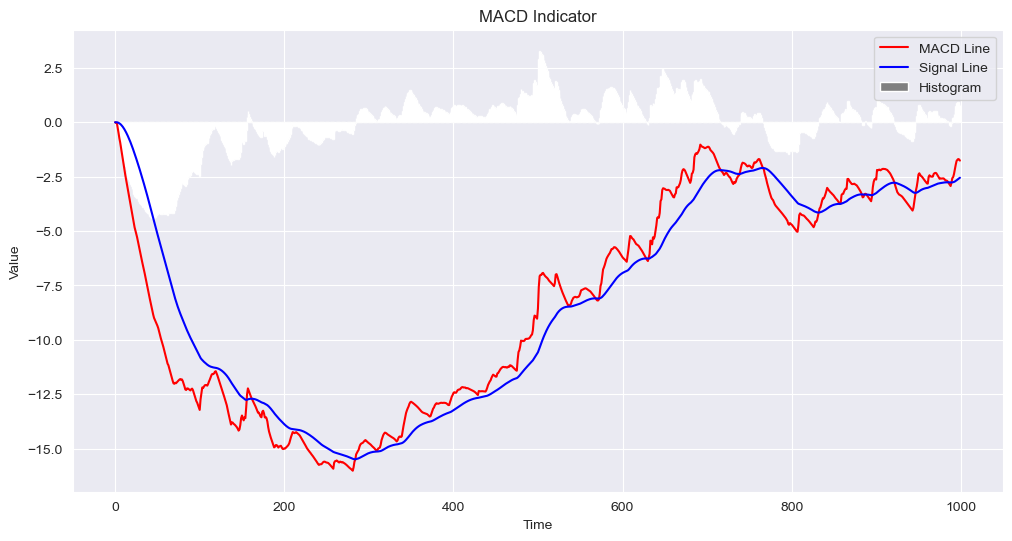

In [98]:
# 绘制MACD和信号线
plt.figure(figsize=(12, 6))
plt.plot(test_set['MACD Line'][:1000], label='MACD Line', color='red')
plt.plot(test_set['MACD Signal'][:1000], label='Signal Line', color='blue')
plt.bar(test_set.index[:1000], test_set['MACD Histogram'][:1000], label='Histogram', color='grey')
plt.legend()
plt.title('MACD Indicator')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [99]:
## generate signal based on MACD
# 通过比较MACD线和信号线的前后值来确定交叉
test_set['MACD Trade Signal'] = 0
test_set.loc[(test_set['MACD Line'] > test_set['MACD Signal']) &  # MACD线上穿信号线
       (test_set['MACD Line'].shift(1) <= test_set['MACD Signal'].shift(1)), 'MACD Trade Signal'] = 1
test_set.loc[(test_set['MACD Line'] < test_set['MACD Signal']) &  # MACD线下穿信号线
       (test_set['MACD Line'].shift(1) >= test_set['MACD Signal'].shift(1)), 'MACD Trade Signal'] = -1

C:\Users\yhb\AppData\Local\Temp\ipykernel_66496\2268479284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['MACD Trade Signal'] = 0


## 2.3 Spread

# 3. Simulate Trading

In [104]:
initial_capital = 10000
capital = initial_capital
has_position = False
trade_log = []
# capital_history = [initial_capital]
current_holdings = 0
transaction_cost = 0.005
# trade_quantity = 1


for i in range(len(test_set)-1):
    # skip the iteration if there is any missing value
    if test_set.iloc[i].isna().any():
        continue
    
    # if capital is less than 50% of the initial capital, stop trading
    # if capital <= 0.5*initial_capital:
    #     print('Capital is less than 50% of the initial capital, stop trading.')
    #     break
    
    current_true = test_set['price'][i] # current true price
    current_predict = loaded_pred_adjusted[i] # current predicted price
    next_predict = loaded_pred_adjusted[i+1] # next predicted price
    
    # adjust the trade quantity based on the volatility. make the trade quantity no more than the max tradeable quantity
    current_volatility_buy = test_set['Volatility Min Ask'].iloc[i ]
    current_volatility_sell = test_set['Volatility Max Bid'].iloc[i ]
    
    # get other indicators
    ofi = test_set['ofi'].iloc[i]
    rsi = test_set['RSI'].iloc[i]
    macd_signal = test_set['MACD Trade Signal'].iloc[i]

    # buy policy: when next price is higher than current price, and macd_signal is 1 (10% increase)
    if not has_position and next_predict > current_predict * 1.1 and macd_signal == 1:
    # if macd_signal == 1 or (ofi > 5 and rsi > 60):

        # buy_price = test_set['Min Ask Price'].iloc[i]
        buy_price = current_true
        buy_quantity = adjust_trade_quantity(current_volatility_buy, test_set['Min Ask Quantity'].iloc[i],
                                             scaler_factor=10)
        capital -= buy_price * buy_quantity * (1 + transaction_cost)
        current_holdings += buy_quantity
        if current_holdings > 0:
            has_position = True
        trade_log.append({'action': 'BUY1', 'Time': test_set['Datetime'].iloc[i], 'price': buy_price,
                          'capital': capital, 'quantity': buy_quantity,
                          'max quantity': test_set['Min Ask Quantity'].iloc[i]})
     
    # buy 2: when has position but next price is much higher than current price and macd_signal is 1 (15% increase)
    if has_position and next_predict> current_predict*1.2:

        # buy_price = test_set['Min Ask Price'].iloc[i]
        buy_price = current_true
        buy_quantity = adjust_trade_quantity(current_volatility_buy, test_set['Min Ask Quantity'].iloc[i],
                                             scaler_factor=10)
        capital -= buy_price * buy_quantity * (1 + transaction_cost)
        current_holdings += buy_quantity
        has_position = True
        trade_log.append({'action': 'BUY2', 'Time': test_set['Datetime'].iloc[i], 'price': buy_price,
                          'capital': capital, 'quantity': buy_quantity,
                          'max quantity': test_set['Min Ask Quantity'].iloc[i]})

    # sell policy: when next price is lower than current price, or macd_signal is -1, sell (10% decrease)
    elif has_position and (next_predict < current_predict * 0.9 or macd_signal == -1):
    # elif has_position and macd_signal == -1 or (ofi < -2 and rsi < 30):
        # sell_price = test_set['Max Bid Price'].iloc[i]
        sell_price = current_true
        sell_quantity = min(current_holdings, adjust_trade_quantity(current_volatility_sell,
                                                                    test_set['Max Bid Quantity'].iloc[i],
                                                                    scaler_factor=20))
        capital += sell_price * sell_quantity * (1 - transaction_cost)
        current_holdings -= sell_quantity
        
        if current_holdings == 0:
            has_position = False
        
        trade_log.append({'action': 'SELL', 'Time': test_set['Datetime'].iloc[i], 'price': sell_price,
                          'capital': capital, 'quantity': sell_quantity,
                          'max quantity': test_set['Max Bid Quantity'].iloc[i]})

    # hold policy: 
    elif has_position and current_true * 0.9 <= next_predict <= current_true * 1.1:
    # elif has_position and macd_signal == 0:
        trade_log.append({'action': 'HOLD', 'Time': test_set['Datetime'].iloc[i],
                          'price': test_set['price'].iloc[i], 'capital': capital,
                          'quantity': current_holdings})

# 计算最终资本
final_capital = capital
profit = final_capital - initial_capital
# 只计算buy和sell的次数
number_of_buy = len([trade for trade in trade_log if trade['action'] in ['BUY1','BUY2']])
number_of_sell = len([trade for trade in trade_log if trade['action'] == 'SELL'])
number_of_hold = len([trade for trade in trade_log if trade['action'] == 'HOLD'])
# number_of_trades = len(trade_log)

# 保留两位小数
# print('Final capital: ', round(final_capital))
print('Profit: ', round(profit))
# print('Final return: ', round(profit / initial_capital * 100, 2), '%')
print('Number of buys: ', number_of_buy)
print('Number of sells: ', number_of_sell)
print('Number of holds: ', number_of_hold)

Profit:  93017
Number of buys:  1195
Number of sells:  1024
Number of holds:  717


### EXP1
buy1: when predictions increase by 10% and macd_signal is 1
buy2: has_position and predictions increase by 20%
sell: when predictions decrease by 10% or macd_signal is -1
hold: when predictions are within 10% of the current price

Profit:  619541 (transaction cost=0.005)
Number of buys:  6008
Number of sells:  5224
Number of holds:  4183

### EXP2
buy1: when predictions increase by 10% and macd_signal is 1 (MACD is calculated based on 300, 600, 60 as short, long and signal)
sell: when predictions decrease by 10% or macd_signal is -1
hold: when predictions are within 10% of the current price

Profit:  69030 (transaction cost=0.005)
Number of buys:  771
Number of sells:  781
Number of holds:  228

### EXP3
buy1: when predictions increase by 10% and macd_signal is 1 (MACD is calculated based on 300, 600, 60 as short, long and signal)
buy2: has_position and predictions increase by 20%
sell: when predictions decrease by 10% or macd_signal is -1
hold: when predictions are within 10% of the current price

Profit:  93017
Number of buys:  1195
Number of sells:  1024
Number of holds:  717